학습 데이터: (567, 51), 테스트 데이터: (244, 51)

=== 모델 학습 및 평가 시작 ===
Logistic Regression (GLM) -> AUC: 0.8226
Random Forest (RF) -> AUC: 0.7792
Gradient Boosting (GBM) -> AUC: 0.8058
Support Vector Machine (SVM) -> AUC: 0.7473
K-Nearest Neighbors (KNN) -> AUC: 0.6297
Naive Bayes (NB) -> AUC: 0.6979


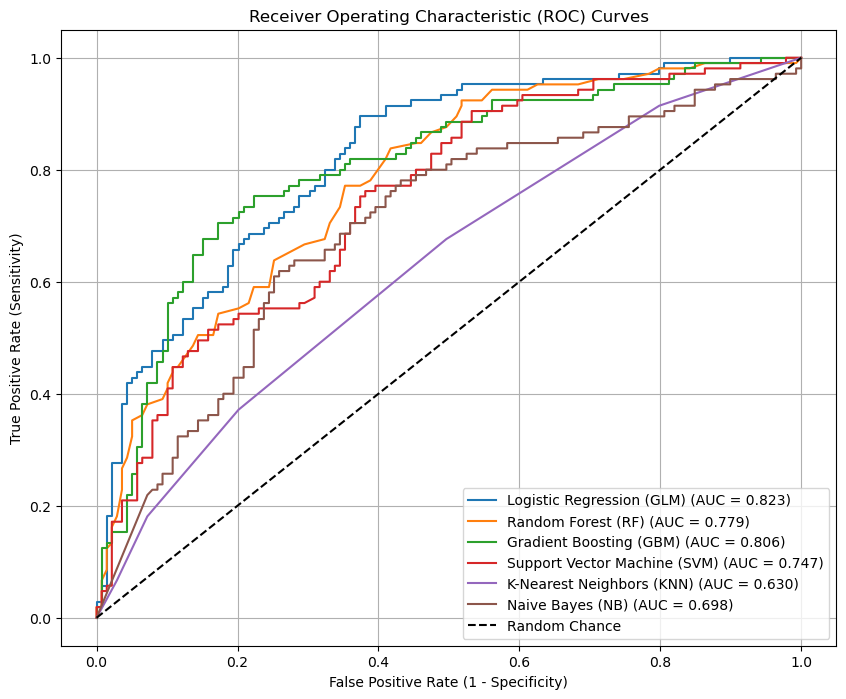


=== 최종 성능 평가 결과 (Test Set) ===
                          Model       AUC  Accuracy  Sensitivity  Specificity
0     Logistic Regression (GLM)  0.822610  0.717213     0.580952     0.820144
2       Gradient Boosting (GBM)  0.805824  0.770492     0.695238     0.827338
1            Random Forest (RF)  0.779205  0.696721     0.590476     0.776978
3  Support Vector Machine (SVM)  0.747311  0.659836     0.552381     0.741007
5              Naive Bayes (NB)  0.697876  0.430328     0.971429     0.021583
4     K-Nearest Neighbors (KNN)  0.629668  0.614754     0.371429     0.798561


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

# ==============================================================================
# 1. 데이터 로드 및 준비
# ==============================================================================
file_path = 'Processed_MIMIC_Data.csv'
df = pd.read_csv(file_path)

# 식별자 컬럼 제거 (학습에 불필요)
identifiers = ['subject_id', 'hadm_id', 'stay_id']
X = df.drop(columns=identifiers + ['aki_outcome'], errors='ignore')
y = df['aki_outcome']

# 데이터 정규화 (스케일링)
# SVM, KNN, Logistic Regression 등은 스케일링이 성능에 중요합니다.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 데이터 분할 (Train 70% : Test 30%) - 논문 방법론 [cite: 112]
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"학습 데이터: {X_train.shape}, 테스트 데이터: {X_test.shape}")

# ==============================================================================
# 2. 모델 정의
# 논문에서 사용한 모델들 중 주요 모델들을 정의합니다. [cite: 31]
# ==============================================================================
models = {
    "Logistic Regression (GLM)": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest (RF)": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting (GBM)": GradientBoostingClassifier(random_state=42), # 논문의 Best Performer
    "Support Vector Machine (SVM)": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
    "Naive Bayes (NB)": GaussianNB()
}

# ==============================================================================
# 3. 모델 학습 및 평가
# ==============================================================================
plt.figure(figsize=(10, 8))

results = []

print("\n=== 모델 학습 및 평가 시작 ===")
for name, model in models.items():
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측 (확률값)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # 성능 지표 계산
    auc = roc_auc_score(y_test, y_pred_prob)
    acc = accuracy_score(y_test, y_pred)
    
    # 민감도(Sensitivity/Recall)와 특이도(Specificity) 계산
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    results.append({
        "Model": name,
        "AUC": auc,
        "Accuracy": acc,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    })
    
    print(f"{name} -> AUC: {auc:.4f}")
    
    # ROC Curve 그리기
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# ==============================================================================
# 4. 결과 시각화 및 저장
# ==============================================================================

# ROC Curve 설정 (논문 Figure 4 재현 [cite: 384])
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('ROC_Curves.png', dpi=300) # 그래프 저장
plt.show()

# 결과 표 출력
results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print("\n=== 최종 성능 평가 결과 (Test Set) ===")
print(results_df)

# 가장 성능이 좋은 모델로 Feature Importance 출력 (트리 기반 모델인 경우)
best_model_name = results_df.iloc[0]['Model']
if "Random Forest" in best_model_name or "Gradient Boosting" in best_model_name:
    best_model = models[best_model_name]
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importances ({best_model_name})")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    plt.savefig('Feature_Importance.png', dpi=300)
    plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

# 1. 데이터 준비
file_path = 'Processed_MIMIC_Data.csv'
df = pd.read_csv(file_path)

identifiers = ['subject_id', 'hadm_id', 'stay_id']
X = df.drop(columns=identifiers + ['aki_outcome'], errors='ignore')
y = df['aki_outcome']

# 스케일링 (트리 기반 모델인 GBM에는 필수는 아니지만, 다른 모델과 비교를 위해 유지)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 2. GBM 모델 및 파라미터 그리드 정의
# 논문 페이지 4, 'Model tuning and testing' 섹션 및 Results 참고
gbm = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],       # 논문 범위: 50 to 200
    'max_depth': [2, 4, 6, 8],                 # 논문 범위: 1 to 8 (간격 조정)
    'learning_rate': [0.1, 0.2, 0.3],          # 논문 범위: 0.1 to 0.3
    'min_samples_leaf': [5, 10, 15, 20]        # 논문 범위: 5 to 20
}

print("=== Grid Search 시작 (시간이 다소 소요됩니다) ===")
# 5-fold 교차 검증을 통해 최적의 파라미터 찾기
grid_search = GridSearchCV(
    estimator=gbm,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1, # CPU 모든 코어 사용
    verbose=1
)

grid_search.fit(X_train, y_train)

# 3. 최적의 파라미터 및 성능 확인
print("\n=== 튜닝 결과 ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.4f}")

# 4. 테스트 셋에서 최종 평가
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

final_auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nTest Set AUC (Tuned GBM): {final_auc:.4f}")
print("-" * 30)

# 논문의 최종 파라미터와 비교 (참고용)
print("참고: 논문의 최종 파라미터 ")
print("- Trees: 50, Depth: 2, Shrinkage: 0.1, Min Node: 10")

=== Grid Search 시작 (시간이 다소 소요됩니다) ===
Fitting 5 folds for each of 192 candidates, totalling 960 fits

=== 튜닝 결과 ===
Best Parameters: {'learning_rate': 0.2, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 100}
Best CV AUC: 0.8266

Test Set AUC (Tuned GBM): 0.7991
------------------------------
참고: 논문의 최종 파라미터 
- Trees: 50, Depth: 2, Shrinkage: 0.1, Min Node: 10



=== 논문 파라미터 적용 결과 ===
GBM Params: Trees=50, Depth=2, LR=0.1, MinLeaf=10
Test Set AUC: 0.8191
Accuracy: 0.7541
Sensitivity: 0.6190
Specificity: 0.8561


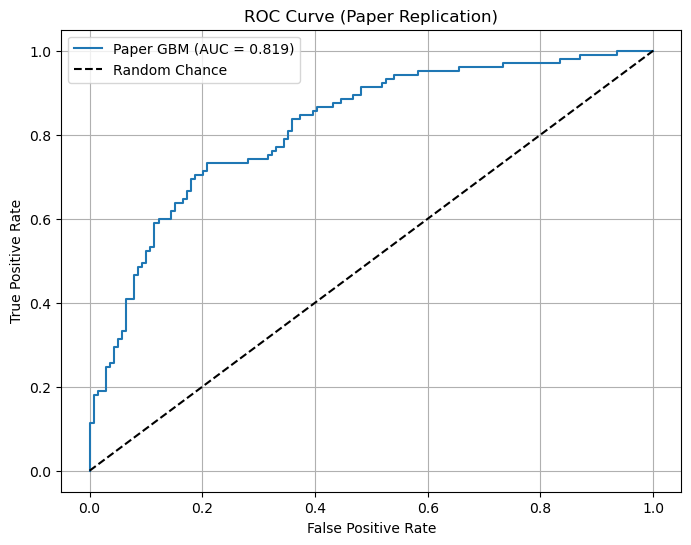

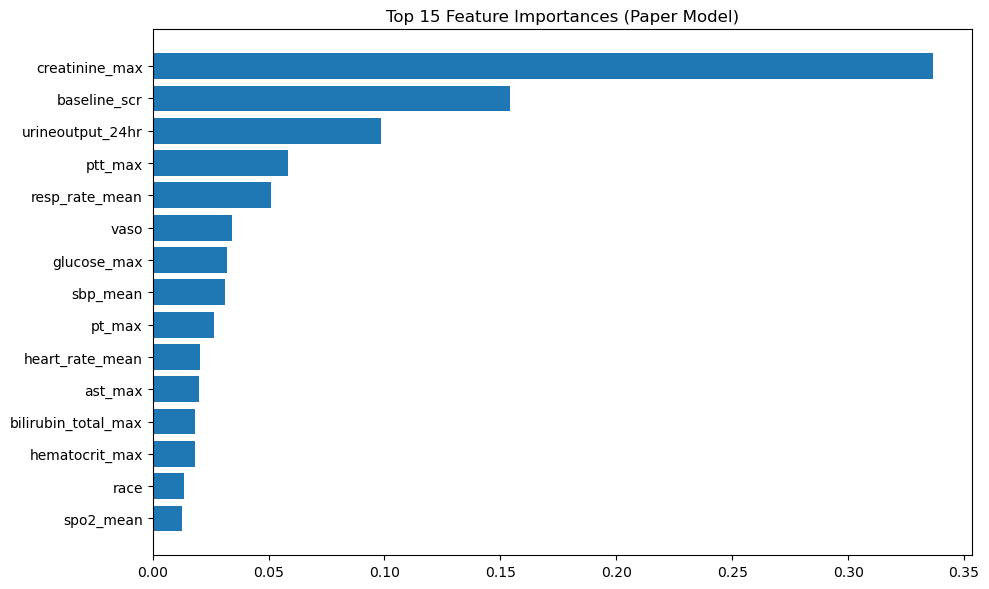

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

# 1. 데이터 준비
file_path = 'Processed_MIMIC_Data.csv'
df = pd.read_csv(file_path)

identifiers = ['subject_id', 'hadm_id', 'stay_id']
X = df.drop(columns=identifiers + ['aki_outcome'], errors='ignore')
y = df['aki_outcome']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# stratify=y를 사용하여 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 2. 모델 정의 (논문의 파라미터 강제 적용)
# [Source 177]: 50 trees, interaction depth 2, shrinkage 0.1, 10 min variables
paper_gbm = GradientBoostingClassifier(
    n_estimators=50,          # 논문: 50
    max_depth=2,              # 논문: 2 (아주 얕은 트리 -> 과적합 방지)
    learning_rate=0.1,        # 논문: 0.1
    min_samples_leaf=10,      # 논문: 10
    random_state=42
)

# 3. 학습 및 평가
paper_gbm.fit(X_train, y_train)

y_pred_prob = paper_gbm.predict_proba(X_test)[:, 1]
y_pred = paper_gbm.predict(X_test)

final_auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"\n=== 논문 파라미터 적용 결과 ===")
print(f"GBM Params: Trees=50, Depth=2, LR=0.1, MinLeaf=10")
print(f"Test Set AUC: {final_auc:.4f}")  # 목표: 0.806 이상, 논문값(0.867) 접근
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Paper GBM (AUC = {final_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Paper Replication)')
plt.legend()
plt.grid(True)
plt.show()

# 5. 변수 중요도 (Feature Importance)
# 논문의 Figure 3과 비교해 보세요 (urineoutput, mv_invas 등이 상위권인지)
importances = paper_gbm.feature_importances_
indices = np.argsort(importances)[::-1][:15] # 상위 15개

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances (Paper Model)")
plt.barh(range(15), importances[indices], align="center")
plt.yticks(range(15), X.columns[indices])
plt.gca().invert_yaxis() # 상위 변수가 위로 오도록
plt.tight_layout()
plt.show()

=== 추가 모델 성능 평가 (AUC) ===
Logistic Regression: 0.8226
Paper GBM: 0.8191


c:\Users\junsy\miniconda3\envs\aki-project\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:18:15] WARNING: D:\bld\xgboost-split_1764148459144\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: 0.8130
LightGBM: 0.8221


c:\Users\junsy\miniconda3\envs\aki-project\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:18:15] WARNING: D:\bld\xgboost-split_1764148459144\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Voting (Ensemble): 0.8365


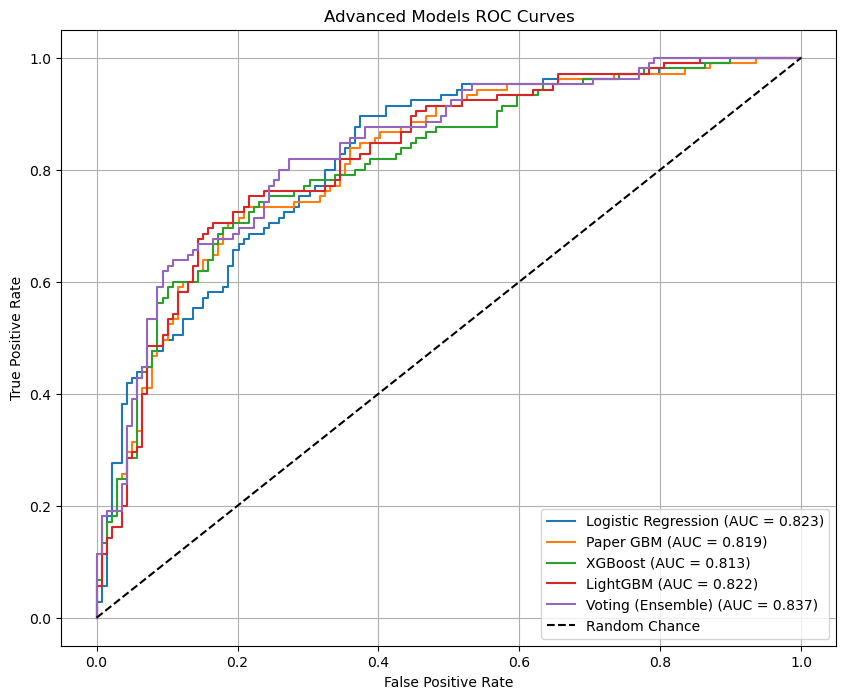

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# XGBoost와 LightGBM 라이브러리 임포트
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. 데이터 로드 및 전처리
file_path = 'Processed_MIMIC_Data.csv'
df = pd.read_csv(file_path)

identifiers = ['subject_id', 'hadm_id', 'stay_id']
X = df.drop(columns=identifiers + ['aki_outcome'], errors='ignore')
y = df['aki_outcome']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Stratify 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 2. 모델 정의
# (1) 기존 우수 모델
glm = LogisticRegression(random_state=42, max_iter=1000)
# 논문 파라미터 적용 GBM
gbm = GradientBoostingClassifier(n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, random_state=42)

# (2) 추가 모델 (XGBoost, LightGBM)
# 과적합 방지를 위해 깊이(max_depth)를 얕게 설정합니다.
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1, 
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

# (3) 앙상블 (Voting)
# 성능이 좋은 GLM, GBM, XGBoost를 섞습니다.
voting_model = VotingClassifier(
    estimators=[
        ('GLM', glm),
        ('GBM', gbm),
        ('XGB', xgb)
    ],
    voting='soft' # 확률을 평균내는 방식
)

# 3. 학습 및 평가
models = {
    "Logistic Regression": glm,
    "Paper GBM": gbm,
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "Voting (Ensemble)": voting_model
}

print("=== 추가 모델 성능 평가 (AUC) ===")
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"{name}: {auc:.4f}")
    
    # ROC Curve 그리기
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# 시각화 설정
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Advanced Models ROC Curves')
plt.legend()
plt.grid(True)
plt.savefig('Advanced_Models_ROC.png', dpi=300)
plt.show()

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Advanced Models (설치가 필요할 수 있음: pip install xgboost lightgbm)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# 1. 데이터 로드 및 전처리
file_path = 'Processed_MIMIC_Data.csv'
df = pd.read_csv(file_path)

# 식별자 제거 및 X, y 분리
identifiers = ['subject_id', 'hadm_id', 'stay_id']
X = df.drop(columns=identifiers + ['aki_outcome'], errors='ignore')
y = df['aki_outcome']

# 데이터 정규화
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 데이터 분할 (Stratify 적용)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# 2. 모델 정의

# (A) 베이스라인 모델
glm = LogisticRegression(random_state=42, max_iter=1000)
rf = RandomForestClassifier(random_state=42, n_estimators=100)
svm = SVC(probability=True, random_state=42)
knn = KNeighborsClassifier()
nb = GaussianNB()
gbm_default = GradientBoostingClassifier(random_state=42)

# (B) 원저 재현 모델 (Paper GBM)
paper_gbm = GradientBoostingClassifier(
    n_estimators=50, 
    max_depth=2, 
    learning_rate=0.1, 
    min_samples_leaf=10, 
    random_state=42
)

# (C) 심화 모델 (Advanced Boosting)
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1, 
    eval_metric='logloss',
    random_state=42
)
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

# (D) 앙상블 (Voting) - GLM + Paper GBM + XGBoost
voting_model = VotingClassifier(
    estimators=[
        ('GLM', glm),
        ('Paper_GBM', paper_gbm),
        ('XGB', xgb)
    ],
    voting='soft'
)

# 모든 모델을 딕셔너리로 통합
models = {
    # 베이스라인
    "Logistic Regression (GLM)": glm,
    "Random Forest (RF)": rf,
    "Support Vector Machine (SVM)": svm,
    "K-Nearest Neighbors (KNN)": knn,
    "Naive Bayes (NB)": nb,
    "Gradient Boosting (Default)": gbm_default,
    
    # 재현 및 심화
    "Paper GBM (Replication)": paper_gbm,
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "Voting Ensemble": voting_model
}

# 3. 모델 학습 및 5대 지표 평가
results = []

print("=== 전체 모델 성능 평가 시작 (시간이 조금 걸릴 수 있습니다) ===")

for name, model in models.items():
    print(f"Testing {name}...")
    # 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # 혼동 행렬 추출
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # --- 5대 지표 계산 ---
    # 1. 민감도 (Sensitivity / Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # 2. 특이도 (Specificity)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # 3. 양성 예측도 (PPV / Precision)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # 4. 음성 예측도 (NPV)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # 5. 정확도 (Accuracy)
    acc = accuracy_score(y_test, y_pred)
    
    # (부록) AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    
    results.append({
        "Model": name,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "PPV (Precision)": ppv,
        "NPV": npv,
        "Accuracy": acc,
        "AUC": auc
    })

# 4. 결과 출력 및 저장
results_df = pd.DataFrame(results)
cols = ['Model', 'Sensitivity', 'Specificity', 'PPV (Precision)', 'NPV', 'Accuracy', 'AUC']
results_df = results_df[cols].sort_values(by='AUC', ascending=False)

print("\n=== 최종 결과 요약 ===")
print(results_df)

# CSV 저장
results_df.to_csv('final_all_models_performance.csv', index=False)
print("\n모든 모델의 결과가 'final_all_models_performance.csv'로 저장되었습니다.")

=== 전체 모델 성능 평가 시작 (시간이 조금 걸릴 수 있습니다) ===
Testing Logistic Regression (GLM)...
Testing Random Forest (RF)...
Testing Support Vector Machine (SVM)...
Testing K-Nearest Neighbors (KNN)...
Testing Naive Bayes (NB)...
Testing Gradient Boosting (Default)...
Testing Paper GBM (Replication)...
Testing XGBoost...
Testing LightGBM...
Testing Voting Ensemble...

=== 최종 결과 요약 ===
                          Model  Sensitivity  Specificity  PPV (Precision)  \
9               Voting Ensemble     0.666667     0.856115         0.777778   
0     Logistic Regression (GLM)     0.580952     0.820144         0.709302   
8                      LightGBM     0.695238     0.834532         0.760417   
6       Paper GBM (Replication)     0.619048     0.856115         0.764706   
7                       XGBoost     0.647619     0.834532         0.747253   
5   Gradient Boosting (Default)     0.695238     0.827338         0.752577   
1            Random Forest (RF)     0.590476     0.776978         0.666667   
2  S